In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
img_size = 256
batch = 32
rgb_channels = 3
epochs = 20
n_classes = 4

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    shuffle= True,
    image_size=(img_size, img_size),
    batch_size= batch
    )

Found 974 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
class_names

['Blackspot', 'Canker', 'Fresh', 'Grenning']

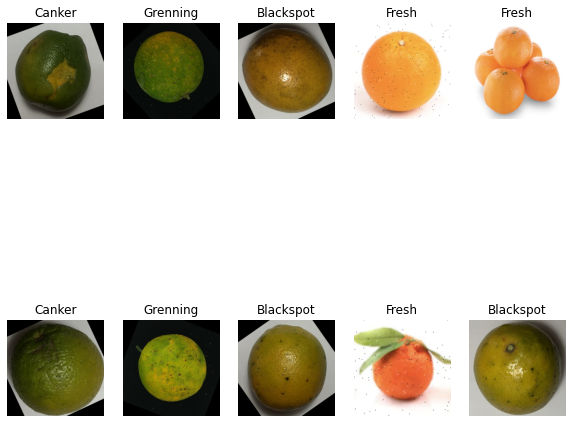

In [5]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [6]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle =True, shuffle_size = 10000):
   
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 6)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train = ds.take(train_size)
    validation = ds.skip(train_size).take(val_size)
    test = ds.skip(train_size).skip(val_size)



    return train, validation, test

In [7]:
train, validation, test = get_dataset_partitions_tf(dataset)

In [8]:
train = train.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [9]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size, img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
 ])

In [10]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

CNN Model

In [11]:
input_shape = (batch, img_size, img_size, rgb_channels)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),  
])
model.build(input_shape = (input_shape))

In [12]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [13]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [14]:
history = model.fit(
    train,
    epochs = epochs,
    batch_size = batch,
    verbose = 1,
    validation_data = validation
)

Epoch 1/20
24/24 [==============================] - 151s 5s/step - loss: 0.9305 - accuracy: 0.6040 - val_loss: 0.5911 - val_accuracy: 0.7708
Epoch 2/20
24/24 [==============================] - 141s 6s/step - loss: 0.4402 - accuracy: 0.7933 - val_loss: 0.3555 - val_accuracy: 0.7917
Epoch 3/20
24/24 [==============================] - 126s 5s/step - loss: 0.3184 - accuracy: 0.8280 - val_loss: 0.2717 - val_accuracy: 0.8333
Epoch 4/20
24/24 [==============================] - 102s 4s/step - loss: 0.3110 - accuracy: 0.8080 - val_loss: 0.2507 - val_accuracy: 0.8854
Epoch 5/20
24/24 [==============================] - 135s 6s/step - loss: 0.2805 - accuracy: 0.8587 - val_loss: 0.2632 - val_accuracy: 0.8438
Epoch 6/20
24/24 [==============================] - 113s 5s/step - loss: 0.2500 - accuracy: 0.8720 - val_loss: 0.2098 - val_accuracy: 0.9062
Epoch 7/20
24/24 [==============================] - 137s 6s/step - loss: 0.2349 - accuracy: 0.8893 - val_loss: 0.2124 - val_accuracy: 0.8854
Epoch 8/20
24

In [15]:
scores = model.evaluate(test)

4/4 [==============================] - 5s 633ms/step - loss: 0.1861 - accuracy: 0.8984


In [16]:
scores

[0.18610164523124695, 0.8984375]

In [17]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 24}

In [18]:
acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

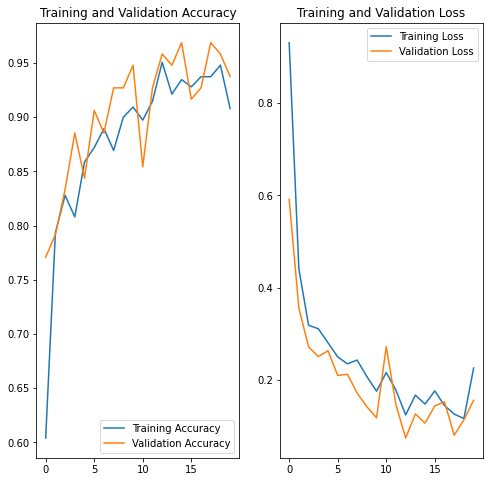

In [19]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label = 'Validation Accuracy')
plt.legend(loc ='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs), loss, label= 'Training Loss')
plt.plot(range(epochs), val_loss, label = 'Validation Loss')
plt.legend(loc ='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(image_batch[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 40ms/step


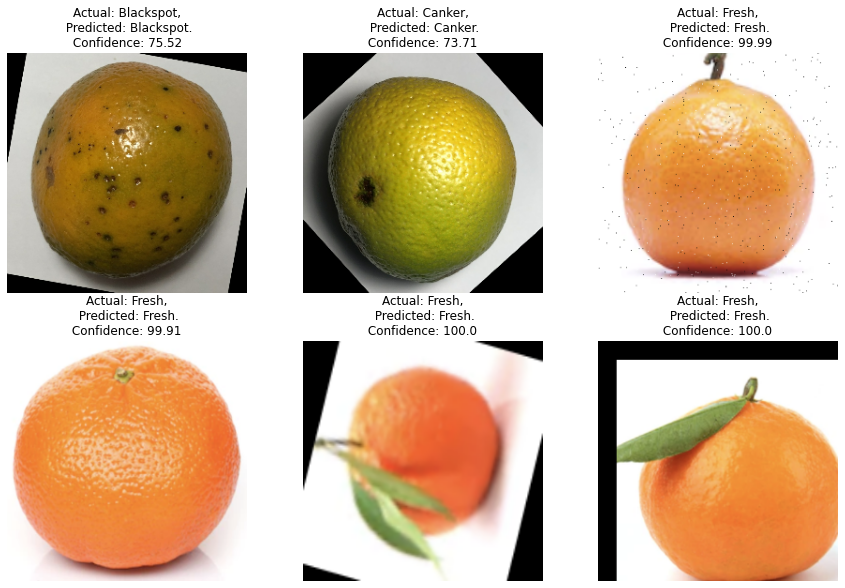

In [59]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in test.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i+1)
        ax.set_facecolor("yellow")
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, image_batch[i].numpy())
        actual_class = class_names[label_batch[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence} ")

        plt.axis("off")
